<a href="https://colab.research.google.com/github/HugoKD/ML/blob/main/multi_armed_bandit_pb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Introduction to Machine learning with multi-arm bandit problem with a dose fiding study


In [ ]:
import numpy as np
import math
from random import choice
import random
from scipy.stats import bernoulli
from typing import Sequence, Tuple
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(8953)
import warnings
warnings.filterwarnings('ignore')

## Dose Finding Study

In the context of clinical trials, Phase I trials are the first stage of testing in human subjects. Their goal is to evaluate the safety (and feasibility) of the treatment and identify its side effects. The aim of a phase I dose-finding study is to determine the most appropriate dose level that should be used in further phases of the clinical trials. Traditionally, the focus is on determining the highest dose with acceptable toxicity called the Maximum Tolerated Dose (MTD).

A dose-finding study involves a number K of dose levels that have been chosen by physicians based on preliminary experiments (K is usually a number between 3 and 10). Denoting by $p_k$ the (unknown) toxicity probability of dose $k$, the Maximum Tolerated Dose (MTD) is defined as the dose with a toxicity probability closest to a target:

\begin{align}
k^* \in \underset{k\in\{1,\dots,K\}}{\mathrm{argmin}}|\theta - p_k|
\end{align}

where $\theta$ is the pre-specified targeted toxicity probability (typically between 0.2 and 0.35).
A MTD identification algorithm proceeds sequentially: at round $t$ a dose $D_t \in \{1, \dots , K\}$ is selected and administered to a patient for whom a toxicity response is observed. A binary outcome $X_t$ is revealed where $X_t = 1$ indicates that a harmful side-effect occurred and $X_t = 0$ indicates than no harmful side-effect occurred. We assume that $X_t$ is drawn from a Bernoulli distribution with mean $p_{D_t}$ and is independent from previous observations.

### Define the Bandit class :


In [ ]:
class Bandit(object):

  def __init__(self,
               n_arm: int = 2,
               n_pulls: int = 2000,
               actual_toxicity_prob: list = [0.4, 0.6],
               theta: float = 0.3,
               ):
    self.n_arm = n_arm
    self.n_pulls = n_pulls
    self.actual_toxicity_prob = actual_toxicity_prob
    self.theta = theta
    self.init_bandit()

  def init_bandit(self):
    """
        Initialize the bandit
    """
    self.num_dose_selected = np.array([0]*self.n_arm) # number of times a dose is selected
    self.num_toxic = np.array([0]*self.n_arm) # number of times a does found to be toxic

  def pull(self, a_idx: int):
    """
    .inputs:
      a_idx: Index of action.
    .outputs:
      rew: reward value.
    """
    assert a_idx < self.n_arm, "invalid action index"

    self.num_dose_selected[a_idx]+=1
    outcome = random.random()
    if outcome < self.actual_toxicity_prob[a_idx]: #réalisation d"une variable de bernouilli de para p=self.actual...[a_idx]
        self.num_toxic[a_idx]+=1
    #problématique, quelle est la probabilité estimée de la toxicité d'un bras ? esperance empirique = self.num_toxic/self.num_selected ?
    p_hat = self.num_toxic[a_idx]/self.num_dose_selected[a_idx]
    rew = - abs(self.theta-p_hat)

    return rew

### Dose finding study with three doses

Let's define a dose finding study with three doses ($K = 3$) where we need to choose from with `actual_toxicity_prob=[0.1, 0.35, 0.8]` and targeted toxicity probability is $\theta = 0.3$.

In [ ]:
#@title Problem definition
bandit = Bandit(n_arm=3, n_pulls=2000, actual_toxicity_prob=[0.1, 0.35, 0.8], theta=0.3)

###  $\epsilon$-greedy for k-armed bandit and Optimistic initial values

#### $\epsilon$-greedy algorithm implementation


In [ ]:
def eps_greedy(
    bandit: Bandit,
    eps: float,
    init_q: float = .0
    ) -> Tuple[list, list, list]:
  """
  .inputs:
    bandit: A bandit problem, instantiated from the above class.
    eps: The epsilon value.
    init_q: Initial estimation of each arm's value.
  .outputs:
    rew_record: The record of rewards at each timestep.
    avg_ret_record: The average of rewards up to step t, where t goes from 0 to n_pulls. For example: If
    we define `ret_T` = \sum^T_{t=0}{r_t}, `avg_ret_record` = ret_T / (1+T).
    tot_reg_record: The  regret up to step t, where t goes from 0 to n_pulls.
    opt_action_perc_record: Percentage of optimal arm selected.
  """
  # initialize q values
  q = np.array([init_q]*bandit.n_arm, dtype=float)

  ret = .0
  rew_record = []
  avg_ret_record = []
  tot_reg_record = []
  opt_action_perc_record = []
  b = bernoulli(1-eps)

  for t in range(bandit.n_pulls):

     # VA bernouilli equals to one= exploitation (with a probability of 1-eps) and zero=exploration
    exp = b.rvs()
    if exp == 1 : #exploit
      Q = max(q)
      a_idx = np.argmax(q)
    else : # explore
      Q = choice(q)
      a_idx = choice(np.where(q == Q)[0])
    #if there is several
    rew = bandit.pull(a_idx)
    rew_record.append(rew)
    ret+=rew # t goes from 0 to t
    avg_ret_record.append(ret/(t+1))
    # find q*
    p_star = bandit.actual_toxicity_prob[0] # est l esperance ?
    q_star= -abs(p_star-bandit.theta)
    opti_index = 0
    for i in range(1,len(bandit.actual_toxicity_prob)):
      x = bandit.actual_toxicity_prob[i]
      if -abs(x-bandit.theta) > q_star:
        q_star, p_star, opti_index= -abs(x-bandit.theta),x, i # la valeur opti est la plus petite valeur de |p_star - theta|
    #regret
    regret = (t+1)*q_star-ret
    tot_reg_record.append(regret)
    # percentage of time optimal value was picked
    #issue here -> the condition is never passed => filled of zero
    if t==0:
      x=0
      if a_idx == opti_index: # in case evry element of actual tox prob is different, elif it return an array
        x=1
      opt_action_perc_record.append(x)
    elif t!=0 :
      x=0
      if a_idx == opti_index:
        x=1
      perc = (opt_action_perc_record[len(opt_action_perc_record)-1]*t+x)/(t+1)
      #nombr de fois qu'il a ete choisi la derniere fois qu'il a ete choisi * denominateur /
      opt_action_perc_record.append(perc)

    #change the estimate value of arm at each step
    #we devide by the number of time a was taken
    #a voir pour pourcentage record car resulat non cohérent
    q[a_idx]+= (1/bandit.num_dose_selected[a_idx])*(rew-q[a_idx])

  return rew_record, avg_ret_record, tot_reg_record, opt_action_perc_record



#### Plotting the results

We use the driver code provided to plot: (1) The average return, (2) The reward, (3) the total regret, and (4) the percentage of optimal action across the $N$=20 runs as a function of the number of pulls (2000 pulls for each run) for all three $\epsilon$ values of 0.5, 0.1, and 0.

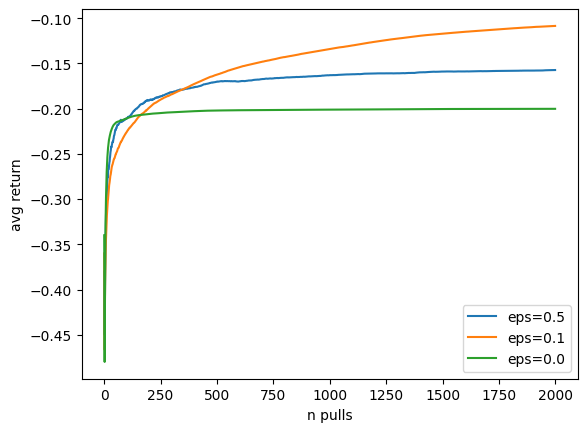

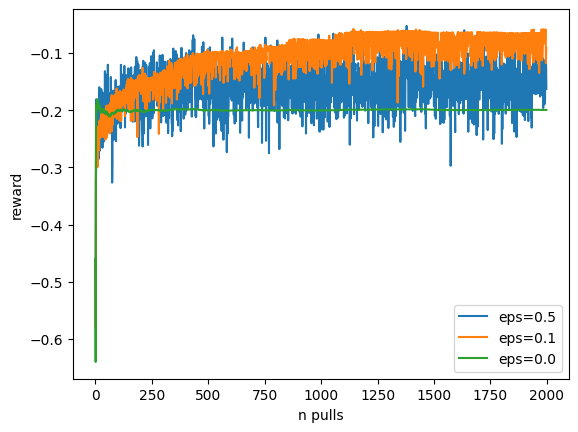

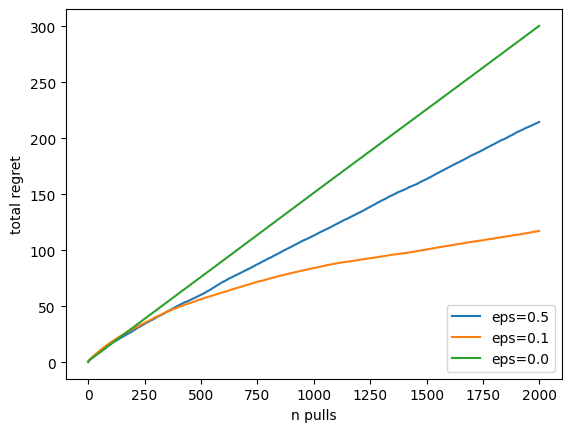

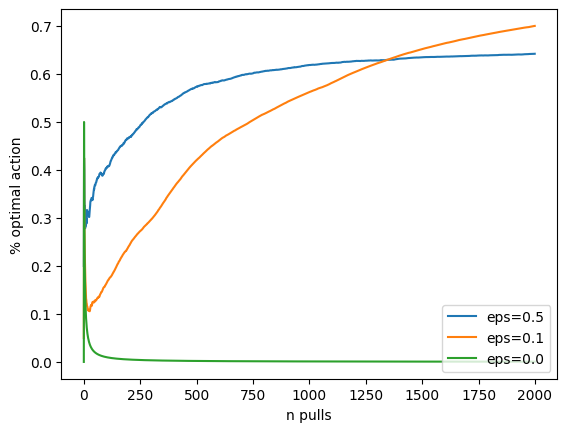

In [ ]:
import time
plt.figure(0)
plt.xlabel("n pulls")
plt.ylabel("avg return")
plt.figure(1)
plt.xlabel("n pulls")
plt.ylabel("reward")
plt.figure(2)
plt.xlabel("n pulls")
plt.ylabel("total regret")
plt.figure(3)
plt.xlabel("n pulls")
plt.ylabel("% optimal action")

N = 20
tot_reg_rec_best = 1e8

for eps in [0.5, 0.1, .0]:
  rew_rec = np.zeros(bandit.n_pulls)
  avg_ret_rec = np.zeros(bandit.n_pulls)
  tot_reg_rec = np.zeros(bandit.n_pulls)
  opt_act_rec = np.zeros(bandit.n_pulls)
  start_time = time.time()
  for n in range(N):
    bandit.init_bandit()
    rew_rec_n, avg_ret_rec_n, tot_reg_rec_n, opt_act_rec_n = eps_greedy(bandit, eps)
    rew_rec += np.array(rew_rec_n)
    avg_ret_rec += np.array(avg_ret_rec_n)
    tot_reg_rec += np.array(tot_reg_rec_n)
    opt_act_rec += np.array(opt_act_rec_n)

  end_time = time.time()
  # print(f"time per run: {end_time - start_time}/N")
  # take the mean
  rew_rec /= N
  avg_ret_rec /= N
  tot_reg_rec /= N
  opt_act_rec /= N

  plt.figure(0)
  plt.plot(avg_ret_rec, label="eps={}".format(eps))
  plt.legend(loc="lower right")

  plt.figure(1)
  plt.plot(rew_rec[1:], label="eps={}".format(eps))
  plt.legend(loc="lower right")

  plt.figure(2)
  plt.plot(tot_reg_rec, label="eps={}".format(eps))
  plt.legend(loc="lower right")

  plt.figure(3)
  plt.plot(opt_act_rec, label="eps={}".format(eps))
  plt.legend(loc="lower right")


  if tot_reg_rec[-1] < tot_reg_rec_best:
        ep_greedy_dict = {
        'opt_act':opt_act_rec,
        'regret_list':tot_reg_rec,}
        tot_reg_rec_best = tot_reg_rec[-1]

#### Analysis

We can see that the optimal value a epsilon is the one that is both enough small to no have the same behaviour that the simple random algorithm, and enough big to explore the other possibilities, and thus don't converge toward a suboptimal action. Thus,the optimal value here is eps = 0.1. We can see that for a eps = 0, the model quickly become a constant function thoughout the iterations, and if the initial value isn't good, the regret is the greatest of all (it has been stuck toward an non optimal action).



####  Optimistic Initial Values

We want to run the optimistic initial value method on the same problem described above for the initial q values of -1 and +1 for all arms. Compare its performance, measured by the average reward across $N$=20 runs as a function of the number of pulls, with the non-optimistic setting with initial q values of 0 for all arms. For both optimistic and non-optimistic settings, $\epsilon$=0.

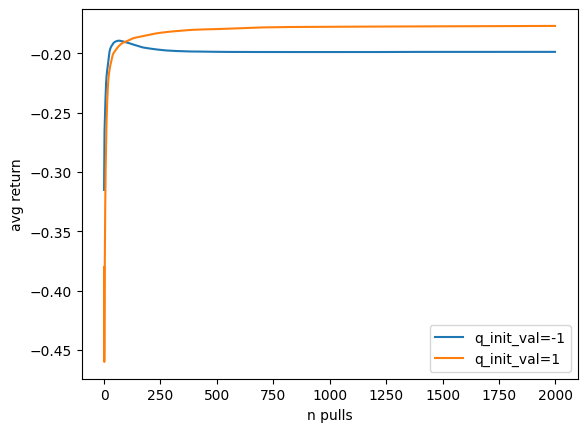

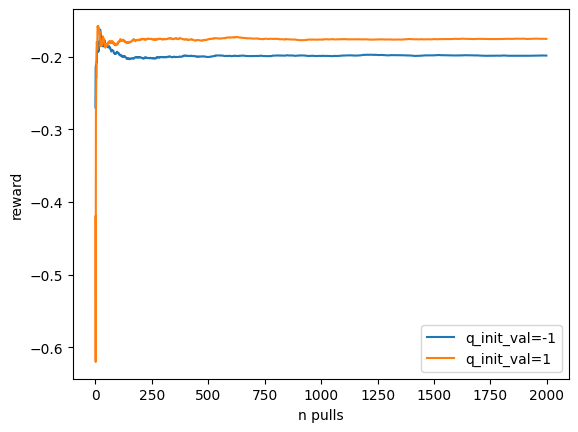

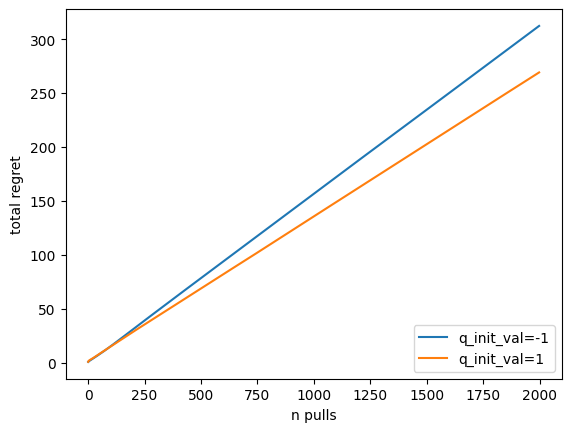

In [ ]:
plt.figure(4)
plt.xlabel("n pulls")
plt.ylabel("avg return")

plt.figure(5)
plt.xlabel("n pulls")
plt.ylabel("reward")

plt.figure(6)
plt.xlabel("n pulls")
plt.ylabel("total regret")

N = 20
for init_q in [-1, 1]:
  rew_rec = np.zeros(bandit.n_pulls)
  avg_ret_rec = np.zeros(bandit.n_pulls)
  for n in range(N):
    bandit.init_bandit()
    rew_rec_n, avg_ret_rec_n, tot_reg_rec_n, opt_act_rec_n = eps_greedy(bandit, eps=0.0, init_q=init_q)

    rew_rec += np.array(rew_rec_n)
    avg_ret_rec += np.array(avg_ret_rec_n)
    tot_reg_rec += np.array(tot_reg_rec_n)

  avg_ret_rec /= N
  rew_rec /= N
  tot_reg_rec /= N
  plt.figure(4)
  plt.plot(avg_ret_rec[1:], label="q_init_val={}".format(init_q))
  plt.legend(loc="lower right")

  plt.figure(5)
  plt.plot(rew_rec[1:], label="q_init_val={}".format(init_q))
  plt.legend(loc="lower right")

  plt.figure(6)
  plt.plot(tot_reg_rec[1:], label="q_init_val={}".format(init_q))
  plt.legend(loc="lower right")

####  Analysis

We can conjecture that, in this case, the greater the q_initial_value is the greater the performance will be. Furthermore, a greater q_initial_value seems to have a positive impact in favor of the exploration. Indeed, it seems that for great value for initiatialization, it takes more time to converge because it promotes exploration more. This phenomenon could be read as a bias.

###Upper-Confidence-Bound action selection

#### UCB algorithm implementation

Implementation of the UCB algorithm on the same MAB problem as above.

In [ ]:
import math
def ucb(
    bandit: Bandit,
    c: float,
    init_q: float = .0
    ) -> Tuple[list, list, list]:
  """
  .inputs:
    bandit: A bandit problem, instantiated from the above class.
    c: The additional term coefficient.
    init_q: Initial estimation of each arm's value.
  .outputs:
    rew_record: The record of rewards at each timestep.
    avg_ret_record: The average summation of rewards up to step t, where t goes from 0 to n_pulls. For example: If
    we define `ret_T` = \sum^T_{t=0}{r_t}, `avg_ret_record` = ret_T / (1+T).
    tot_reg_record: The  regret up to step t, where t goes from 0 to n_pulls.
    opt_action_perc_record: Percentage of optimal arm selected.
  """
  # init q values (the estimates)
  q = np.array([init_q]*bandit.n_arm, dtype=float)

  ret = .0
  rew_record = []
  avg_ret_record = []
  tot_reg_record = []
  opt_action_perc_record = []

  for t in range(bandit.n_pulls):
    # Assuming to take the first arm always when there is no exploration

    #choice of action

    q_star,a_idx = q[0]+c*(math.log(t+1)/bandit.num_dose_selected[0])**0.5,0

    for i in range(1,bandit.n_arm): #argmax a
      x =q[i]+c*(math.log(t+1)/bandit.num_dose_selected[i])**0.5
      if x > q_star:
        q_star, a_idx = x,i


    rew = bandit.pull(a_idx)
    rew_record.append(rew)
    ret+=rew
    avg_ret_record.append(ret/(t+1))
    # find q*
    p_star = bandit.actual_toxicity_prob[0]
    q_star= -abs(p_star-bandit.theta)
    opti_index = 0
    for i in range(1,len(bandit.actual_toxicity_prob)):
      x = bandit.actual_toxicity_prob[i]
      if -abs(x-bandit.theta) > q_star:
        q_star, p_star, opti_index= -abs(x-bandit.theta),x, i # la valeur opti est la plus petite valeur de |p_star - theta|
    #regret
    regret = (t+1)*q_star-ret
    tot_reg_record.append(regret)
    # percentage of time optimal value was picked
    #issue here -> the condition is never passed => filled of zero
    if t==0:
      x=0
      if a_idx == opti_index: # in case evry element of actual tox prob is different, elif it return an array
        x=1
      opt_action_perc_record.append(x)
    elif t!=0 :
      x=0
      if a_idx == opti_index:
        x=1
      perc = (opt_action_perc_record[len(opt_action_perc_record)-1]*t+x)/(t+1)
      #nombr de fois qu'il a ete choisi la derniere fois qu'il a ete choisi * denominateur /
      opt_action_perc_record.append(perc)

    q[a_idx]+= (1/bandit.num_dose_selected[a_idx])*(rew-q[a_idx])


  return rew_record, avg_ret_record, tot_reg_record, opt_action_perc_record

####  Plotting the results

We use the driver code provided to plot: (1) The average return, (2) The reward, (3) the total regret, and (4) the percentage of optimal action across the $N$=20 runs as a function of the number of pulls (2000 pulls for each run) for three values of $c$=0, 0.5, and 2.0.

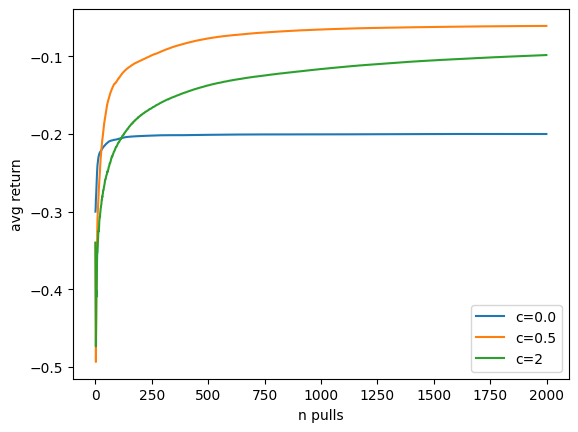

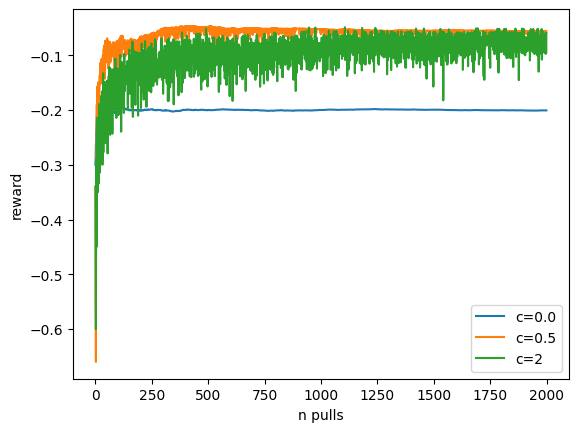

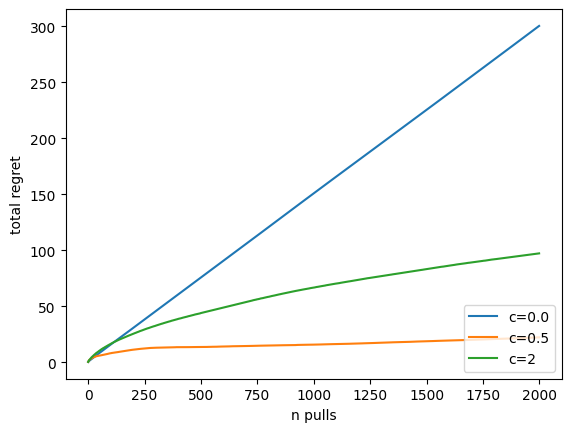

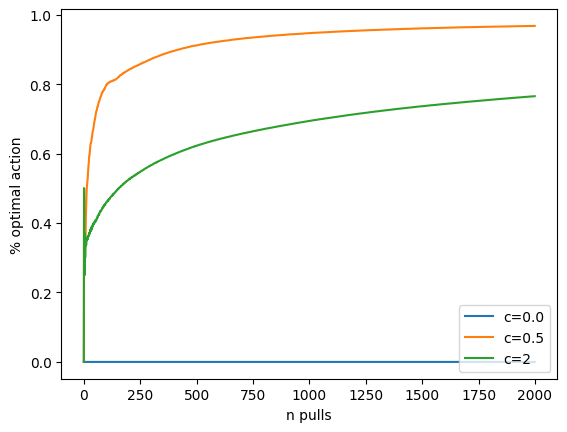

In [ ]:
plt.figure(7)
plt.xlabel("n pulls")
plt.ylabel("avg return")
plt.figure(8)
plt.xlabel("n pulls")
plt.ylabel("reward")
plt.figure(9)
plt.xlabel("n pulls")
plt.ylabel("total regret")
plt.figure(10)
plt.xlabel("n pulls")
plt.ylabel("% optimal action")

N = 20
tot_reg_rec_best = 1e8
for c in [.0, 0.5, 2]:
  rew_rec = np.zeros(bandit.n_pulls)
  avg_ret_rec = np.zeros(bandit.n_pulls)
  tot_reg_rec = np.zeros(bandit.n_pulls)
  opt_act_rec = np.zeros(bandit.n_pulls)

  for n in range(N):
    bandit.init_bandit()
    rew_rec_n, avg_ret_rec_n, tot_reg_rec_n, opt_act_rec_n = ucb(bandit, c)
    rew_rec += np.array(rew_rec_n)
    avg_ret_rec += np.array(avg_ret_rec_n)
    tot_reg_rec += np.array(tot_reg_rec_n)
    opt_act_rec += np.array(opt_act_rec_n)

  # take the mean
  rew_rec /= N
  avg_ret_rec /= N
  tot_reg_rec /= N
  opt_act_rec /= N

  plt.figure(7)
  plt.plot(avg_ret_rec, label="c={}".format(c))
  plt.legend(loc="lower right")

  plt.figure(8)
  plt.plot(rew_rec, label="c={}".format(c))
  plt.legend(loc="lower right")

  plt.figure(9)
  plt.plot(tot_reg_rec, label="c={}".format(c))
  plt.legend(loc="lower right")

  plt.figure(10)
  plt.plot(opt_act_rec, label="c={}".format(c))
  plt.legend(loc="lower right")

  if tot_reg_rec[-1] < tot_reg_rec_best:
        ucb_dict = {
        'opt_act':opt_act_rec,
        'regret_list':tot_reg_rec,}
        tot_reg_rec_best = tot_reg_rec[-1]

#### Analysis


Increasing the value of 'c' enhances the exploration aspect as it amplifies the confidence bound term in the UCB (Upper Confidence Bound) formula. Conversely, reducing 'c' diminishes the exploration element, prioritizing the exploitation of arms with higher estimated values. It's evident that when 'c' is set too high, there is greater fluctuation in rewards. Generally speaking, the optimal 'c' value tends to be moderately sized, around 0.5 in this case. This choice of 'c' results in the lowest regret, by a significant margin, and also yields the optimal action. Furthermore, it exhibits much faster convergence compared to when 'c' is set to 2. On the contrary, 'c' equal to 0 is counterproductive because it causes the model to get stuck in a particular action and overly relies on the initializations.

### Boltzmann algorithm
####  Boltzmann policy implementation

Implementation of a Boltzmann policy that gets an array and temprature value ($\tau$) and returns an index sampled from the Boltzmann policy.

In [ ]:
def boltzmann_policy(x, tau):
    """ Returns softmax probabilities with temperature tau
        Input:  x -- 1-dimensional array
        Output: idx -- chosen index
    """
    P= []
    for elmt in x:
      s = 0
      num = math.exp(elmt/tau)
      for y in x :
        s+=math.exp(y/tau)
      P.append(num/s)
    value = random.choices(x,P)[0]
    for i in range(len(x)):#have the index
      if x[i]==value:
        idx=i
        break

    return idx

####  Boltzmann algorithm implementation

---

Evaluatation of the Boltzmann algorithm on the same MAB problem as above, for three values of the parameters $\tau$: $0.01$, $0.1$, and $1$. Use the driver code provided to plot their performances across $N$=20 runs as a function of the number of pulls.



In [ ]:
def boltzmann(
    bandit: Bandit,
    tau: float = 0.1,
    init_q: float = .0
    ) -> Tuple[list, list, list]:
  """
  .inputs:
    bandit: A bandit problem, instantiated from the above class.
    c: The additional term coefficient.
    init_q: Initial estimation of each arm's value.
  .outputs:
    rew_record: The record of rewards at each timestep.
    avg_ret_record: The average summation of rewards up to step t, where t goes from 0 to n_pulls. For example: If
    we define `ret_T` = \sum^T_{t=0}{r_t}, `avg_ret_record` = ret_T / (1+T).
    tot_reg_record: The  regret up to step t, where t goes from 0 to n_pulls.
    opt_action_perc_record: Percentage of optimal arm selected.
  """
  # init q values (the estimates)
  q = np.array([init_q]*bandit.n_arm, dtype=float)

  ret = .0
  rew_record = []
  avg_ret_record = []
  tot_reg_record = []
  opt_action_perc_record = []

  for t in range(bandit.n_pulls):

    a_idx = boltzmann_policy(q,tau)

    rew = bandit.pull(a_idx)
    rew_record.append(rew)
    ret+=rew
    avg_ret_record.append(ret/(t+1))
    # find q*
    p_star = bandit.actual_toxicity_prob[0]
    q_star= -abs(p_star-bandit.theta)
    opti_index = 0
    for i in range(1,len(bandit.actual_toxicity_prob)):
      x = bandit.actual_toxicity_prob[i]
      if -abs(x-bandit.theta) > q_star:
        q_star, p_star, opti_index= -abs(x-bandit.theta),x, i # la valeur opti est la plus petite valeur de |p_star - theta|
    #regret
    regret = (t+1)*q_star-ret
    tot_reg_record.append(regret)
    # percentage of time optimal value was picked
    #issue here -> the condition is never passed => filled of zero
    if t==0:
      x=0
      if a_idx == opti_index: # in case evry element of actual tox prob is different, elif it return an array
        x=1
      opt_action_perc_record.append(x)
    elif t!=0 :
      x=0
      if a_idx == opti_index:
        x=1
      perc = (opt_action_perc_record[len(opt_action_perc_record)-1]*t+x)/(t+1)
      #nombr de fois qu'il a ete choisi la derniere fois qu'il a ete choisi * denominateur /
      opt_action_perc_record.append(perc)

    q[a_idx]+= (1/bandit.num_dose_selected[a_idx])*(rew-q[a_idx])

  return rew_record, avg_ret_record, tot_reg_record, opt_action_perc_record

#### Q1.d3: Plotting the results (5 points)

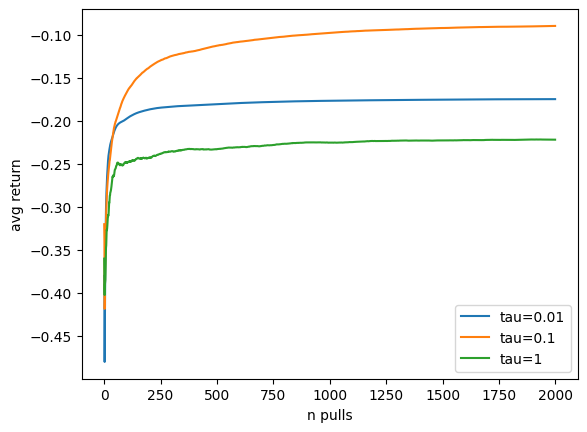

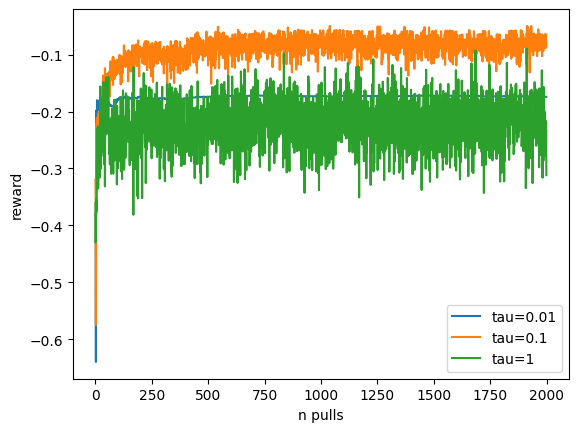

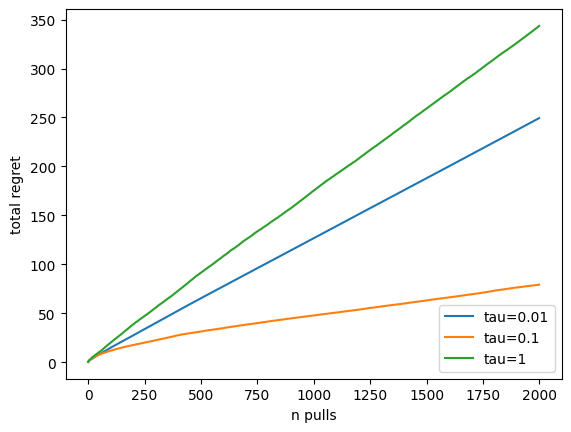

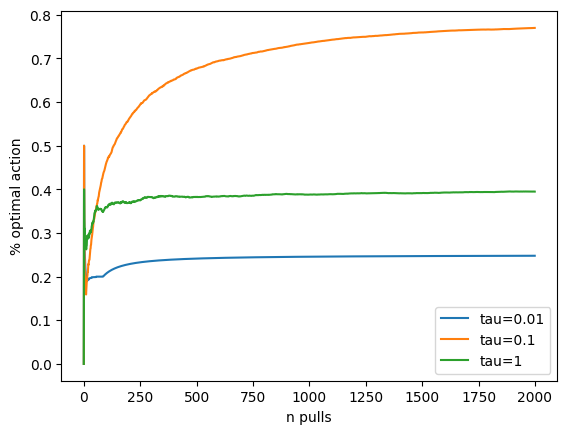

In [ ]:
plt.figure(11)
plt.xlabel("n pulls")
plt.ylabel("avg return")
plt.figure(12)
plt.xlabel("n pulls")
plt.ylabel("reward")
plt.figure(13)
plt.xlabel("n pulls")
plt.ylabel("total regret")
plt.figure(14)
plt.xlabel("n pulls")
plt.ylabel("% optimal action")

N = 20
tot_reg_rec_best = 1e8
for tau in [0.01, 0.1, 1]:
  rew_rec = np.zeros(bandit.n_pulls)
  avg_ret_rec = np.zeros(bandit.n_pulls)
  tot_reg_rec = np.zeros(bandit.n_pulls)
  opt_act_rec = np.zeros(bandit.n_pulls)

  for n in range(N):
    bandit.init_bandit()
    rew_rec_n, avg_ret_rec_n, tot_reg_rec_n, opt_act_rec_n = boltzmann(bandit, tau=tau)
    rew_rec += np.array(rew_rec_n)
    avg_ret_rec += np.array(avg_ret_rec_n)
    tot_reg_rec += np.array(tot_reg_rec_n)
    opt_act_rec += np.array(opt_act_rec_n)

  # take the mean
  rew_rec /= N
  avg_ret_rec /= N
  tot_reg_rec /= N
  opt_act_rec /= N

  plt.figure(11)
  plt.plot(avg_ret_rec, label="tau={}".format(tau))
  plt.legend(loc="lower right")

  plt.figure(12)
  plt.plot(rew_rec, label="tau={}".format(tau))
  plt.legend(loc="lower right")

  plt.figure(13)
  plt.plot(tot_reg_rec, label="tau={}".format(tau))
  plt.legend(loc="lower right")

  plt.figure(14)
  plt.plot(opt_act_rec, label="tau={}".format(tau))
  plt.legend(loc="lower right")

  if tot_reg_rec[-1] < tot_reg_rec_best:
        boltzmann_dict = {
        'opt_act':opt_act_rec,
        'regret_list':tot_reg_rec,}
        tot_reg_rec_best = tot_reg_rec[-1]

####  Analysis

We can see that when tau become greater, the curve varies widely(value spreading). Indeed it is because boltzmann probabilities all become the same (beeing ~1/|actions|), thus the every probability become the same (uniform distribution). We can say that it is therefor in favor of exploration (the model pick an action rondomly). On the contrary, a too little tau, may lead to exploit an no optimal action and mainly relying on the initial estimation  values (the blue reward curve became constant very quicly with respect to the number of iterations but the pourcentage optiaml action is the worst of all). Here, Tau = 0.1, seems to be the good configuration for the problem.

###  Gradient Bandits Algorithm

####  GB implementation  


In [ ]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [ ]:
def gradient_bandit(
    bandit: Bandit,
    alpha: float,
    use_baseline: bool = True,
    ) -> Tuple[list, list, list]:
  """
  .inputs:
    bandit: A bandit problem, instantiated from the above class.
    alpha: The learning rate.
    use_baseline: Whether or not use avg return as baseline.
  .outputs:
    rew_record: The record of rewards at each timestep.
    avg_ret_record: The average summation of rewards up to step t, where t goes from 0 to n_pulls. For example: If
    we define `ret_T` = \sum^T_{t=0}{r_t}, `avg_ret_record` = ret_T / (1+T).
    tot_reg_record: The  regret up to step t, where t goes from 0 to n_pulls.
    opt_action_perc_record: Percentage of optimal arm selected.
  """
  # init h (the logits)
  h = np.array([0]*bandit.n_arm, dtype=float) #preference of each action

  ret = .0
  r_bar_t = 0
  rew_record = []
  avg_ret_record = []
  tot_reg_record = []
  opt_action_perc_record = []

  for t in range(bandit.n_pulls):


    P = softmax(h)
    a_idx = random.choices(range(len(h)),P)[0]  #have the index

    rew = bandit.pull(a_idx)
    rew_record.append(rew)
    ret+=rew
    avg_ret_record.append(ret/(t+1))

    # find q*
    p_star = bandit.actual_toxicity_prob[0]
    q_star= -abs(p_star-bandit.theta)
    opti_index = 0
    for i in range(1,len(bandit.actual_toxicity_prob)):
      x = bandit.actual_toxicity_prob[i]
      if -abs(x-bandit.theta) > q_star:
        q_star, p_star, opti_index= -abs(x-bandit.theta),x, i # la valeur opti est la plus petite valeur de |p_star - theta|

    #regret
    #since we are not intersted in the estimation of the action value we juste take the actual probability
    regret = (t+1)*q_star-ret
    tot_reg_record.append(regret)
    # percentage of time optimal value was picked
    #issue here -> the condition is never passed => filled of zero
    if t==0:
      x=0
      if a_idx == opti_index: # in case evry element of actual tox prob is different, elif it return an array
        x=1
      opt_action_perc_record.append(x)
    elif t!=0 :
      x=0
      if a_idx == opti_index:
        x=1
      perc = (opt_action_perc_record[len(opt_action_perc_record)-1]*t+x)/(t+1)
      #nombr de fois qu'il a ete choisi la derniere fois qu'il a ete choisi * denominateur /
      opt_action_perc_record.append(perc)

      ###update### issue with that part
      if use_baseline == True :
        for i in range(len(h)):
          if i==a_idx:
            h[i]+= alpha*(rew-r_bar_t)*(1-P[a_idx])
          else:
            h[i]+= -alpha*(rew-r_bar_t)*(P[a_idx])
      else :
        for i in range(len(h)):
          if i==a_idx:
            h[i]+= alpha*rew*(1-P[a_idx])
          else:
            h[i]+= -alpha*rew*(P[a_idx])
      r_bar_t=(r_bar_t*t+rew)/(t+1)
    # ----------------------------------------------
  return rew_record, avg_ret_record, tot_reg_record, opt_action_perc_record

#### Plotting the results

Evaluatation of the GB algorithm on the same MAB problem as above, for three values of the parameters $\alpha$: $0.05$, $0.1$, and $2$. Use the driver code provided to plot their performances.

**With baseline:**

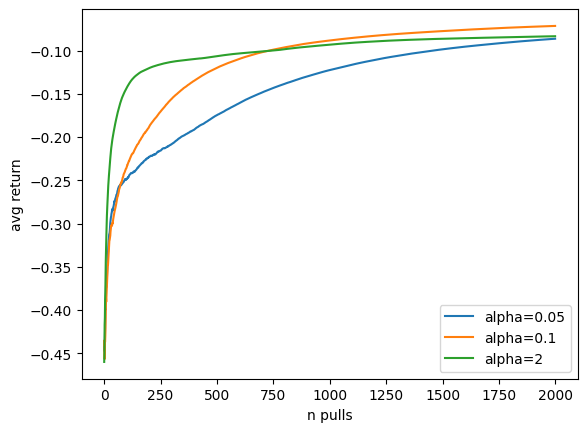

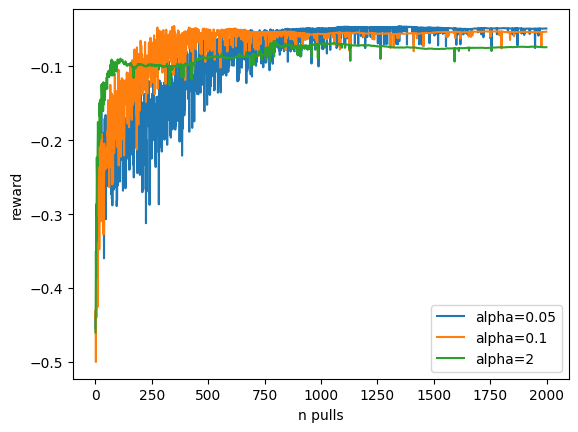

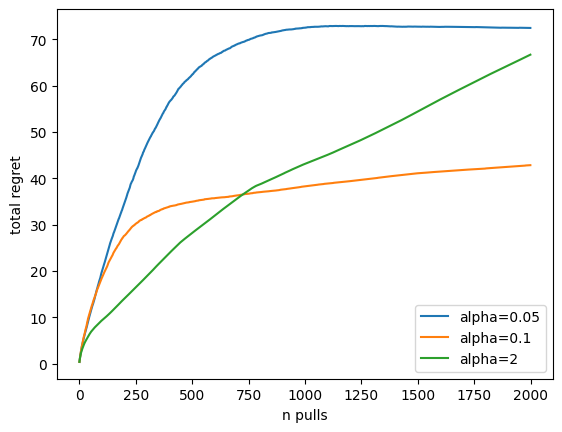

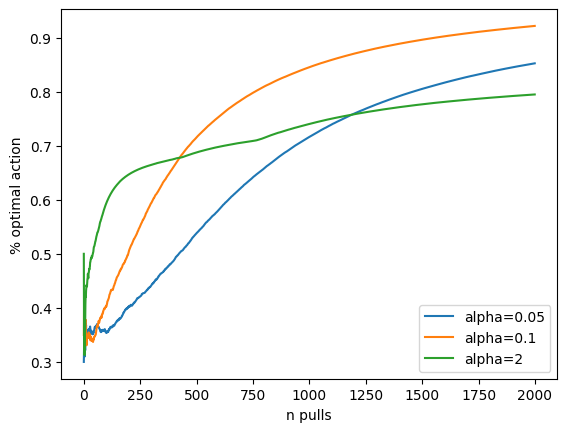

In [ ]:
plt.figure(15)
plt.xlabel("n pulls")
plt.ylabel("avg return")
plt.figure(16)
plt.xlabel("n pulls")
plt.ylabel("reward")
plt.figure(17)
plt.xlabel("n pulls")
plt.ylabel("total regret")
plt.figure(18)
plt.xlabel("n pulls")
plt.ylabel("% optimal action")

N = 20
tot_reg_rec_best = 1e8
for alpha in [0.05, 0.1, 2]:
  rew_rec = np.zeros(bandit.n_pulls)
  avg_ret_rec = np.zeros(bandit.n_pulls)
  tot_reg_rec = np.zeros(bandit.n_pulls)
  opt_act_rec = np.zeros(bandit.n_pulls)

  for n in range(N):
    bandit.init_bandit()
    rew_rec_n, avg_ret_rec_n, tot_reg_rec_n, opt_act_rec_n = gradient_bandit(bandit, alpha=alpha)
    rew_rec += np.array(rew_rec_n)
    avg_ret_rec += np.array(avg_ret_rec_n)
    tot_reg_rec += np.array(tot_reg_rec_n)
    opt_act_rec += np.array(opt_act_rec_n)


  # take the mean
  rew_rec /= N
  avg_ret_rec /= N
  tot_reg_rec /= N
  opt_act_rec /= N


  plt.figure(15)
  plt.plot(avg_ret_rec, label="alpha={}".format(alpha))
  plt.legend(loc="lower right")

  plt.figure(16)
  plt.plot(rew_rec, label="alpha={}".format(alpha))
  plt.legend(loc="lower right")

  plt.figure(17)
  plt.plot(tot_reg_rec, label="alpha={}".format(alpha))
  plt.legend(loc="lower right")

  plt.figure(18)
  plt.plot(opt_act_rec, label="alpha={}".format(alpha))
  plt.legend(loc="lower right")

  if tot_reg_rec[-1] < tot_reg_rec_best:
        gradient_bandit_dict = {
        'opt_act':opt_act_rec,
        'regret_list':tot_reg_rec,}
        tot_reg_rec_best = tot_reg_rec[-1]

**Without baseline:**

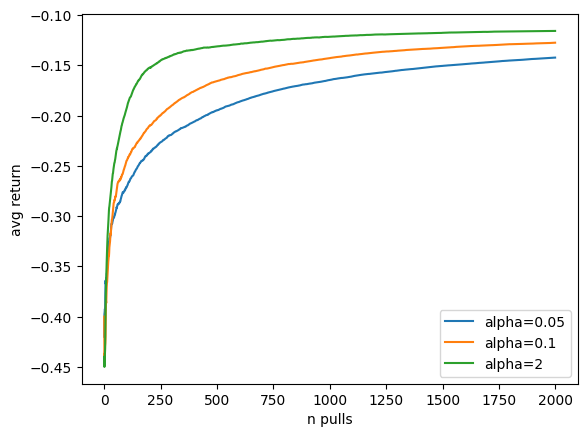

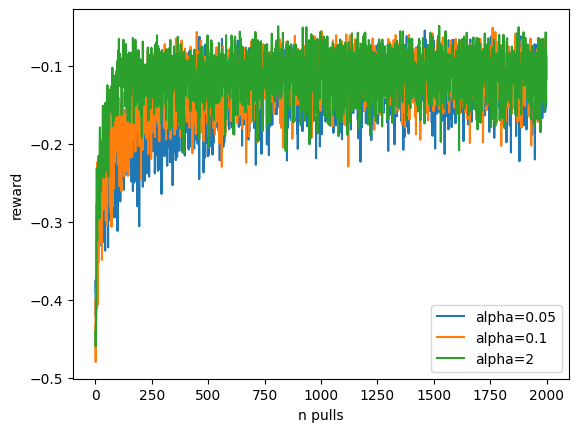

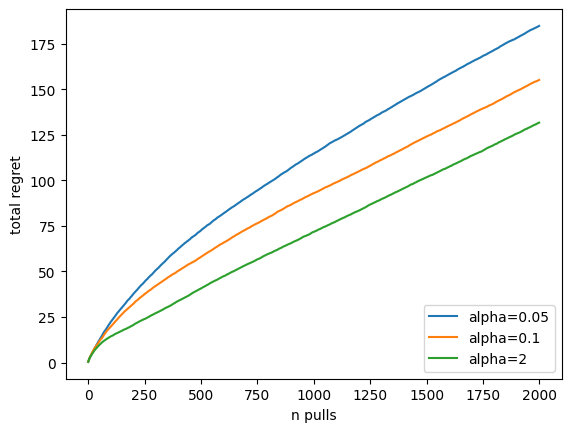

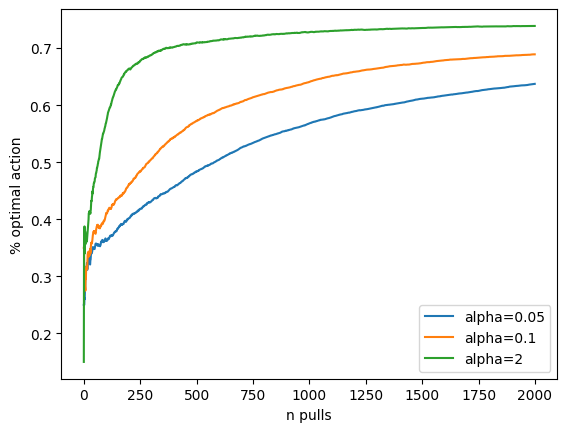

In [ ]:
plt.figure(19)
plt.xlabel("n pulls")
plt.ylabel("avg return")
plt.figure(20)
plt.xlabel("n pulls")
plt.ylabel("reward")
plt.figure(21)
plt.xlabel("n pulls")
plt.ylabel("total regret")
plt.figure(22)
plt.xlabel("n pulls")
plt.ylabel("% optimal action")

N = 20
tot_reg_rec_best = 1e8
for alpha in [0.05, 0.1, 2]:
  rew_rec = np.zeros(bandit.n_pulls)
  avg_ret_rec = np.zeros(bandit.n_pulls)
  tot_reg_rec = np.zeros(bandit.n_pulls)
  opt_act_rec = np.zeros(bandit.n_pulls)

  for n in range(N):
    bandit.init_bandit()
    rew_rec_n, avg_ret_rec_n, tot_reg_rec_n, opt_act_rec_n = gradient_bandit(bandit, alpha=alpha, use_baseline=False)
    rew_rec += np.array(rew_rec_n)
    avg_ret_rec += np.array(avg_ret_rec_n)
    tot_reg_rec += np.array(tot_reg_rec_n)
    opt_act_rec += np.array(opt_act_rec_n)


  # take the mean
  rew_rec /= N
  avg_ret_rec /= N
  tot_reg_rec /= N
  opt_act_rec /= N

  plt.figure(19)
  plt.plot(avg_ret_rec, label="alpha={}".format(alpha))
  plt.legend(loc="lower right")

  plt.figure(20)
  plt.plot(rew_rec, label="alpha={}".format(alpha))
  plt.legend(loc="lower right")

  plt.figure(21)
  plt.plot(tot_reg_rec, label="alpha={}".format(alpha))
  plt.legend(loc="lower right")

  plt.figure(22)
  plt.plot(opt_act_rec, label="alpha={}".format(alpha))
  plt.legend(loc="lower right")

  if tot_reg_rec[-1] < tot_reg_rec_best:
        gradient_bandit_dict = {
        'opt_act':opt_act_rec,
        'regret_list':tot_reg_rec,}
        tot_reg_rec_best = tot_reg_rec[-1]

#### Analysis

 The learning ratencontrols how quickly the action preferences are updated in response to observed rewards. Indeed we can see that a greater α, favors the exploration and here gives the optimal model. On the other hand, a lower α makes the updates more conservative, leading to slower exploration and more reliance on historical preferences.
 Moreover, we can clearly see from the plots, that one of the rôle of the baseline is the model stability. In fact, we can see that without the baseline the model have an higher variance (more fluctuation). In our case, it has also improove the result in general (% optimal action higher with baseline that without).


### Final comaprison

#### plots
Now we compare the performance of $\epsilon$-greedy, UCB, Boltzmann algorithm, and Gradient Bandit algorithm in a single plot as measured by the average reward and total regret.

Text(0, 0.5, 'total regret')

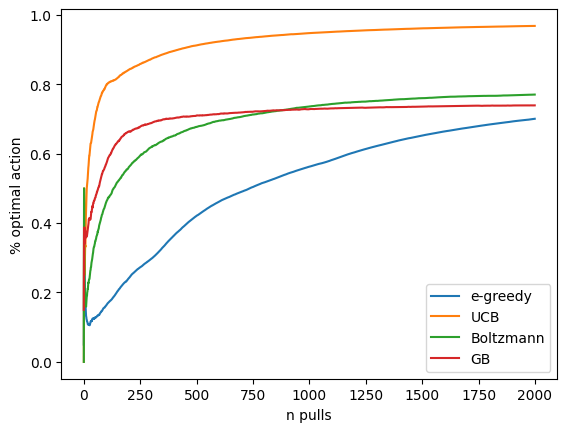

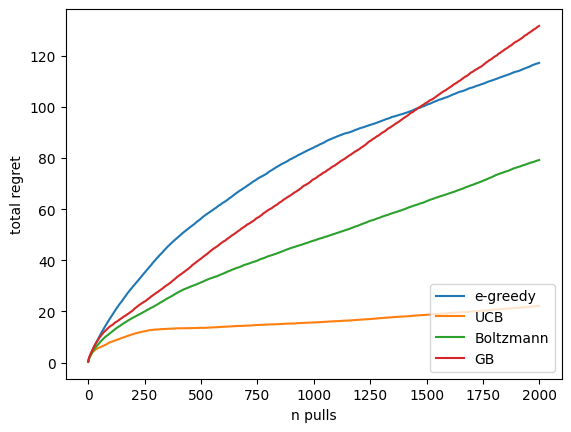

In [ ]:
plt.figure(23)
plt.plot(ep_greedy_dict["opt_act"], label="e-greedy")
plt.legend(loc="lower right")
plt.plot(ucb_dict["opt_act"], label="UCB")
plt.legend(loc="lower right")
plt.plot(boltzmann_dict["opt_act"], label="Boltzmann")
plt.legend(loc="lower right")
plt.plot(gradient_bandit_dict["opt_act"], label="GB")
plt.legend(loc="lower right")
plt.xlabel("n pulls")
plt.ylabel("% optimal action")

plt.figure(24)
plt.plot(ep_greedy_dict["regret_list"], label="e-greedy")
plt.legend(loc="lower right")
plt.plot(ucb_dict["regret_list"], label="UCB")
plt.legend(loc="lower right")
plt.plot(boltzmann_dict["regret_list"], label="Boltzmann")
plt.legend(loc="lower right")
plt.plot(gradient_bandit_dict["regret_list"], label="GB")
plt.legend(loc="lower right")
plt.xlabel("n pulls")
plt.ylabel("total regret")

Eventually from the mere plots, we can say that UCB is the best model by far in our case(both for the total regret and the % of optimal action).

In [ ]:
plt.close('all')

<!-- END QUESTION -->

